### Loading the Libraries

In [ ]:
# Installing Packages
install.packages("tidymodels");
install.packages("aod")
install.packages("ggcorrplot");

In [ ]:
library(tidyverse)
library(ggcorrplot)
library(tidymodels)
library(readr)
library(aod)
library(glmnet)

### Exploratory Analysis: Finding Explanatory Variables
#### Read the training and test data into R

In [173]:
#Reading the dataset into R
train <- read.csv("train.csv") 
train$Customer_Churn <- as.factor(train$Customer_Churn) #Turn from Integer into a factor

#Reading the testing set into R
test <- read.csv("test.csv")
test$Customer_Churn <- as.factor(test$Customer_Churn) # Turn Churn from integer into a factor

# Separate data based on customer churning
churn <- train |> filter(Customer_Churn == 1)
non_churn <- train |> filter(Customer_Churn == 0)

#### Correlation between Variables
We can observe that AI interaction level and customer churn has a negative correlation, implying that the interaction level plays a role in whether a customer will churn. While age only has a slight positive correlation with churn, we can observe that age and AI interaction level has a high positive correlation, which suggests that older individuals tend to not interact with AI services as much as younger individuals. 


   0    1 
2909 2091 

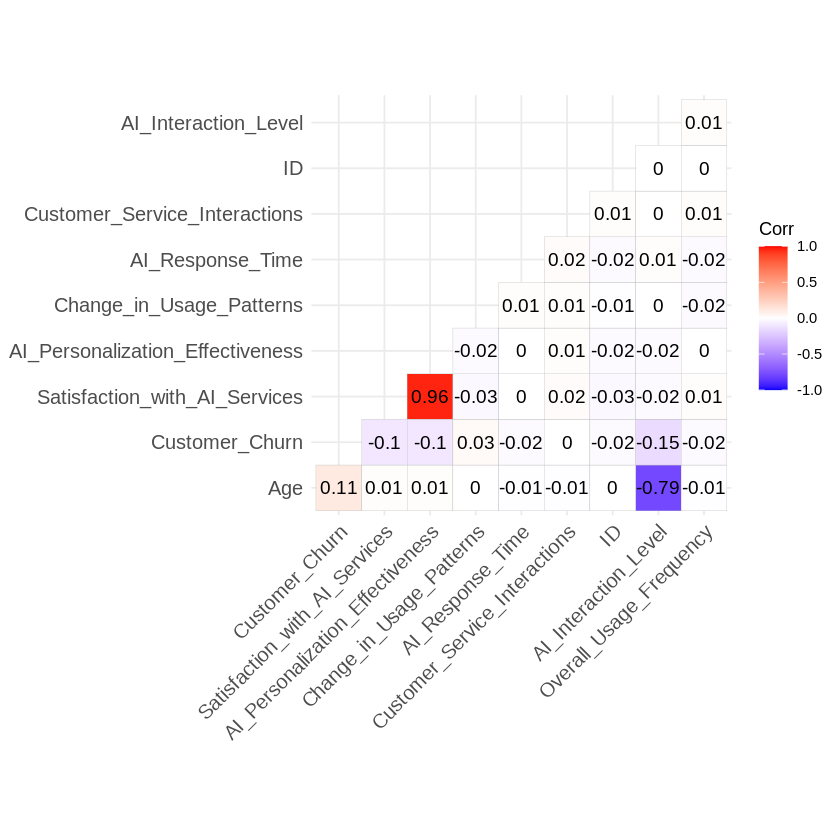

In [194]:
# standardized_data <- train_sample |> 
#                     select(-ID, -Customer_Churn) |>
#                     mutate_all(~(scale(.) %>% as.vector))

train_non_factor <- train
train_non_factor$Customer_Churn <- as.numeric(train$Customer_Churn)

# Correlation for different combinations of variables
correlation<- train_non_factor |> cor(use="complete.obs") # find the correlation
ggcorrplot(correlation, 
          hc.order = TRUE, 
          lab = TRUE, 
          type = "lower");

# Comparing the Variables
compare_customers <- function(){
    ggplot(churn, aes(x = Customer_Churn, color = as.factor(AI_Interaction_Level))) +
    geom_histogram(fill = "white", bins = 10)
}

table(train$Customer_Churn)

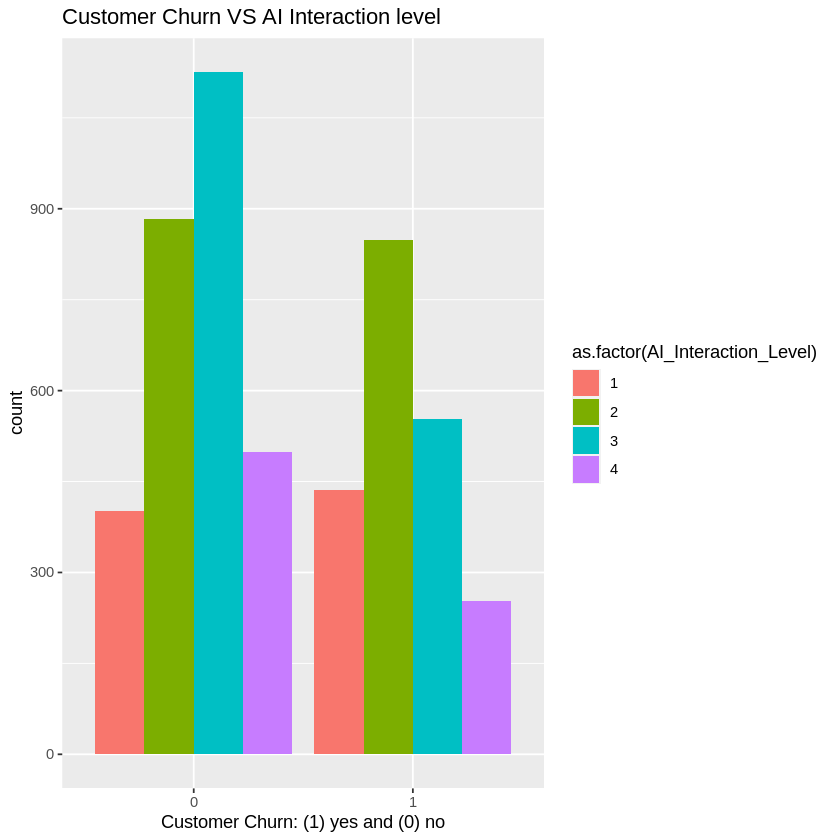

In [210]:
ggplot(train, aes(x = Customer_Churn, fill = as.factor(AI_Interaction_Level), group = AI_Interaction_Level)) +
    geom_bar(position = "dodge") +
    labs(x = "Customer Churn: (1) yes and (0) no", 
         title = "Customer Churn VS AI Interaction level")

### Preparing the Classification Model

#### Preprocessing the data: Selecting the Explanatory Variables

In [212]:
# Setting the seed for reproducibility
set.seed(2024) 

# Have equal number of Churned customers and unchurned customers
churn_sample <- rep_sample_n(churn, reps =1, size= 2090) 
non_churn_sample <- rep_sample_n(non_churn, reps=1, size=2090) 
            
#Combine the samples from Churned and Unchurned
train_sample <- rbind(churn_sample, non_churn_sample) |>
                ungroup() |>
                select(-replicate) |>
                select(ID, Customer_Churn, AI_Interaction_Level, AI_Personalization_Effectiveness)

# Standardize the variables
head(train_sample)

ID,Customer_Churn,AI_Interaction_Level,AI_Personalization_Effectiveness
<int>,<fct>,<int>,<int>
3800,1,2,7
1261,1,2,8
1626,1,2,7
3024,1,2,1
2118,1,3,10
247,1,3,6


### Attempting Logistic Regression
#### Assumptions
1. **No Multicolinearity:** The explanatory variables must be re**No Multicolinearity:** latively independent - that means two chosen variables cannot have a high correlation (`AI_Personalization_Effectiveness`, `AI_Interaction_Level`)
2. **Independent Observations**
3. **Binary Outcomes** - Determine whether a customer is at risk of churning - Churn (1) or No Churn (0)
4. **Large Data Set** - Each class has at least 2000 observations.

In [213]:
## Intialize the logistic Regression model
model <- logistic_reg(penalty = 0.0001,
                      mixture = ,
                     engine = "glmnet", 
                     mode = "classification") |>
          fit(Customer_Churn ~ ., data = train_sample)

# Make a prediction for the test data
pred_class <- predict(model, new_data = test, type = "class") 
results <- test |>
    select(Customer_Churn) |>
    bind_cols(pred_class)

# Assessing the results
#Generate the confusion matrix
conf_mat(results, truth = Customer_Churn,
         estimate = .pred_class)

# Assess the Accuracy
precision(results, 
          truth = Customer_Churn,
          estimate = .pred_class)

          Truth
Prediction   0   1
         0 379 186
         1 335 350

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6707965


In [218]:
# Downloading Prediction
write.csv(results, "prediction.csv")

### Robustness of Classifier: Cross Validation